In [1]:
import sys
sys.path.append("../mypkg")

In [2]:
from constants import RES_ROOT, FIG_ROOT, DATA_ROOT
from utils.misc import load_pkl, save_pkl, merge_intervals
from utils.colors import qual_cmap
from lwci_tmp import LocalConformalInference

In [3]:
%load_ext autoreload
%autoreload 2
# 0,1, 2, 3, be careful about the space

In [4]:
import torch
import scipy.stats as ss
import numpy as np
from easydict import EasyDict as edict
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict as ddict
from tqdm import tqdm, trange
import random
from joblib import Parallel, delayed
import pandas as pd
from pprint import pprint
from copy import deepcopy
from sklearn.linear_model import LinearRegression
plt.style.use(FIG_ROOT/"base.mplstyle")

# Params

In [131]:


def get_simple_data(n, d):
    mean = np.zeros(d)  # mean vector
    cov = np.eye(d)  # identity covariance matrix
    
    # Generate samples
    X = np.random.multivariate_normal(mean, cov, n)
    
    Y_mean = X @ (np.ones(d)/d * 0.5)
    Y_sigma = np.sqrt(np.abs(np.sin(X)) @ np.ones(d))
    Y = np.random.randn(n) * Y_sigma + Y_mean
    return X, Y

def _get_res(Xtest, Ytest, lci, h=0.1):
    alpha = 0.1
    def _inner_fn(tmpX, tmpY):
        lci.add_data(tmpX)
        if h <= 0:
            intvs = lci(alpha=alpha);
        else:
            intvs = lci(local_method="g-rlcp", alpha=alpha, lm_params={"h":h});
        intvs = np.array(intvs);
        prbs = np.bitwise_and(tmpY<= intvs[:, 1], tmpY>=intvs[:, 0]).mean()
        mlen = np.mean(intvs[:, 1] - intvs[:, 0])
        return (prbs, mlen)
    d = Xtest.shape[1]
    Xtest_norm = np.linalg.norm(Xtest, axis=1)
    tau_d = np.sqrt(d * (1-2/9/d)**3)
    
    kpidx1 = Xtest_norm <= tau_d
    kpidx2 = Xtest_norm > tau_d
    res = []
    res.append(_inner_fn(Xtest, Ytest))
    res.append(_inner_fn(Xtest[kpidx1], Ytest[kpidx1]))
    res.append(_inner_fn(Xtest[kpidx2], Ytest[kpidx2]))
    res = np.array(res)
    res_df = {
       "data": ["all", "set1", "set1c"], 
       "prb": res[:, 0], 
       "len": res[:, 1], 
    }
    return pd.DataFrame(res_df)
    


In [151]:
from lwci_tmp import log_norm_kernel
from torch.distributions.multivariate_normal import MultivariateNormal
h = 1.5
d = 40
n = 1000
cov_mat = torch.eye(d)*h*h
sps = MultivariateNormal(loc=torch.zeros(d), 
                         covariance_matrix=torch.eye(d)*1*1).sample((n, ))
sps1 = MultivariateNormal(loc=torch.zeros(d), 
                         covariance_matrix=torch.eye(d)*1*1).sample((n, ))
sps2 = MultivariateNormal(loc=torch.zeros(d), 
                         covariance_matrix=cov_mat).sample((n, ));

In [153]:
log_norm_kernel(sps, sps1+sps2, h=1.5)

tensor([[-45.9995, -44.8835, -32.8726,  ..., -48.9654, -40.8461, -48.9219],
        [-27.5452, -33.3539, -26.4790,  ..., -32.5189, -32.4895, -29.4106],
        [-38.8708, -32.4052, -31.4784,  ..., -50.3679, -47.2340, -30.7887],
        ...,
        [-38.3905, -38.5756, -31.6727,  ..., -38.7988, -39.1665, -48.4433],
        [-42.8422, -52.7812, -56.8166,  ..., -47.7759, -44.8852, -49.5535],
        [-44.7865, -46.1495, -51.4711,  ..., -47.8504, -58.3426, -40.2554]])

In [156]:
log_norm_kernel(sps1, sps1+sps2, vec=True, h=1.5);

In [157]:
n = 2000
ntest = 2000
ncal = 2000

2000

In [142]:
d = 40
h = 0
X, Y = get_simple_data(n=n, d=d)
clf = LinearRegression().fit(X, Y)
def gen_fn(X):
    if isinstance(X, torch.Tensor):
        X = X.numpy()
    Y = clf.predict(X)
    return torch.tensor(Y)
def _run_fn(rep_ix):
    Xcal, Ycal = get_simple_data(n=ncal, d=d)
    Xtest, Ytest = get_simple_data(n=ntest, d=d)
    lci = LocalConformalInference(cal_X=Xcal, cal_Y=Ycal, 
                                  gen_fn=gen_fn, verbose=0)
    re = _get_res(Xtest, Ytest, lci, h=h)
    return re
_run_fn(0)

,data,prb,len
0,all,0.905500,16.158094
1,set1,0.913592,16.158094
2,set1c,0.896907,16.158094


In [163]:
ds = [2, 4, 6, 8, 10, 14, 18, 22, 26, 30, 34, 38]
d = 1
h = 0
num_rep = 10
ress = []
for d in tqdm(ds):
    X, Y = get_simple_data(n=n, d=d)
    clf = LinearRegression().fit(X, Y)
    def gen_fn(X):
        if isinstance(X, torch.Tensor):
            X = X.numpy()
        Y = clf.predict(X)
        return torch.tensor(Y)
    def _run_fn(rep_ix):
        Xcal, Ycal = get_simple_data(n=ncal, d=d)
        Xtest, Ytest = get_simple_data(n=ntest, d=d)
        lci = LocalConformalInference(cal_X=Xcal, cal_Y=Ycal, 
                                      gen_fn=gen_fn, verbose=0)
        re = _get_res(Xtest, Ytest, lci, h=h)
        return re
    with Parallel(n_jobs=10) as parallel:
        res = parallel(delayed(_run_fn)(rep_ix) 
                       for sub_ix in range(num_rep))
    ress.append(res)

100%|████████████████████████████████████████████████████████████████████████████| 12/12 [00:15<00:00,  1.26s/it]


In [164]:
ress_prbs = ddict(list)
for res in ress:
    for ix in range(3):
        ress_prbs[res[0]["data"][ix]].append([re["prb"][ix] for re in res])

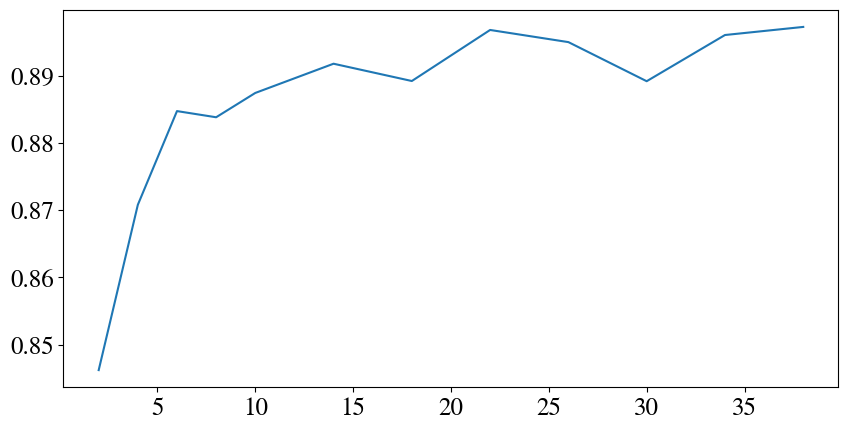

In [165]:
plt.plot(ds, np.array(ress_prbs["set1c"]).mean(axis=1))